In [1]:
# entrando na venv
activate_this = '../venv/bin/activate_this.py' # caminho relativo do venv
exec(open(activate_this).read(), {'__file__': activate_this})

In [2]:
# importando
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [3]:
# gera dos dados
class AlgebraicDataset(Dataset):
    def __init__(self, f, interval, nsamples):
        X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
        self.data = [(x, f(x)) for x in X]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
# arquitetura da rede
class MultiLayerNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
# escolhe entre cpu e gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [6]:
multimodel = MultiLayerNetwork().to(device)

In [7]:
from math import sin
# seta a função
f = lambda x: sin(x)

In [8]:
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [9]:
train_dataset = AlgebraicDataset(f, interval, train_nsamples)
test_dataset = AlgebraicDataset(f, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, test_nsamples, shuffle=True)

In [10]:
lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(multimodel.parameters(), lr=0.03)

In [11]:
def train(model, dataloader, lossfunc, optimizer):
    model.train()
    cumloss = 0.0
    for X, y in dataloader:
        X = X.unsqueeze(1).float().to(device)
        y = y.unsqueeze(1).float().to(device)

        pred = model(X)
        loss = lossfunc(pred, y)

        # zera os gradientes acumulados
        optimizer.zero_grad()
        # computa os gradientes
        loss.backward()
        # anda, de fato, na direção que reduz o erro local
        optimizer.step()

        # loss é um tensor; item pra obter o float
        cumloss += loss.item() 

    return cumloss / len(dataloader)

In [12]:
def test(model, dataloader, lossfunc):
    model.eval()

    cumloss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.unsqueeze(1).float().to(device)
            y = y.unsqueeze(1).float().to(device)

            pred = model(X)
            loss = lossfunc(pred, y)
            cumloss += loss.item() 

    return cumloss / len(dataloader)

In [13]:
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.grid(True, which='both')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    samples = np.linspace(interval[0], interval[1], nsamples)
    model.eval()
    with torch.no_grad():
        pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

    ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
    ax.plot(samples, pred.cpu(), label="model")
    plt.legend()
    plt.show()

Epoch: 0; Train Loss: 0.5013130307197571


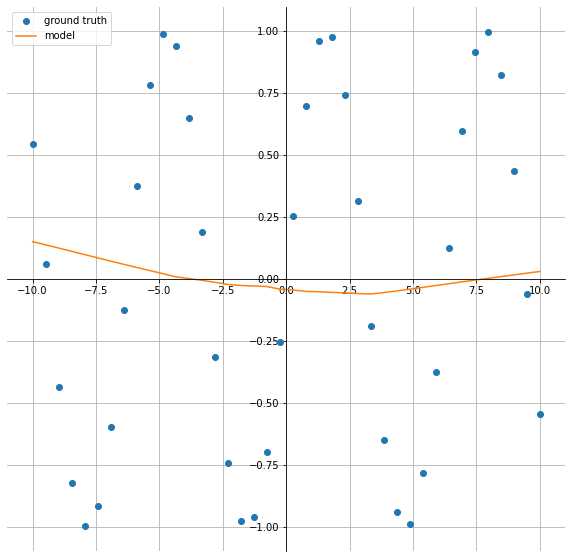

Epoch: 1000; Train Loss: 0.10497546195983887


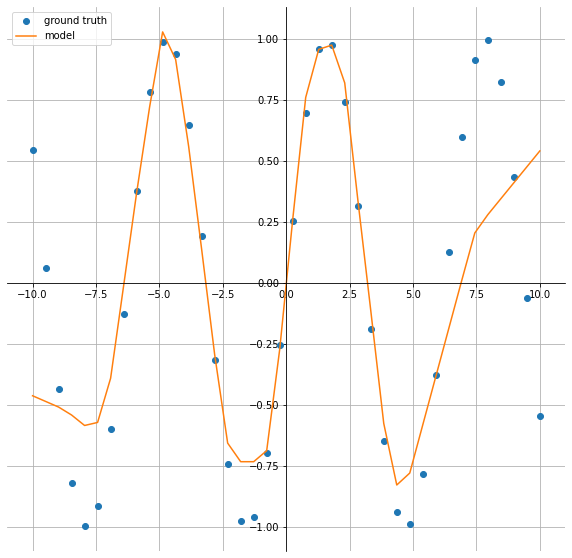

Epoch: 2000; Train Loss: 0.0734846219420433


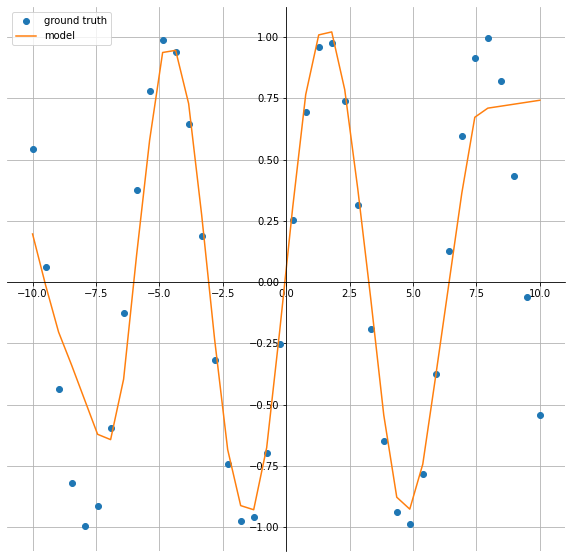

Epoch: 3000; Train Loss: 0.055736247450113297


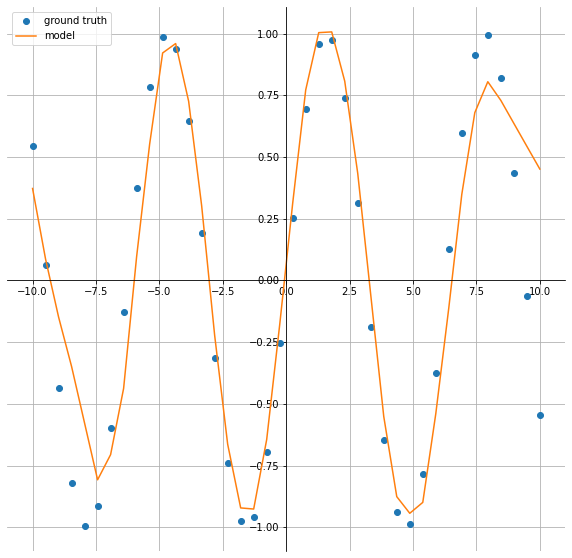

Epoch: 4000; Train Loss: 0.04278090223670006


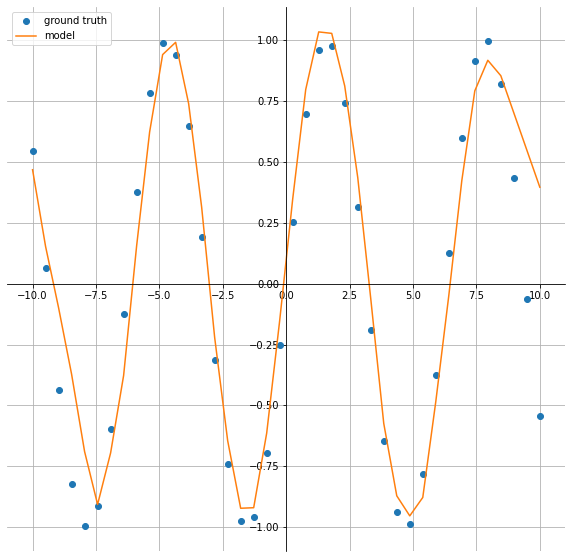

Epoch: 5000; Train Loss: 0.037554167211055756


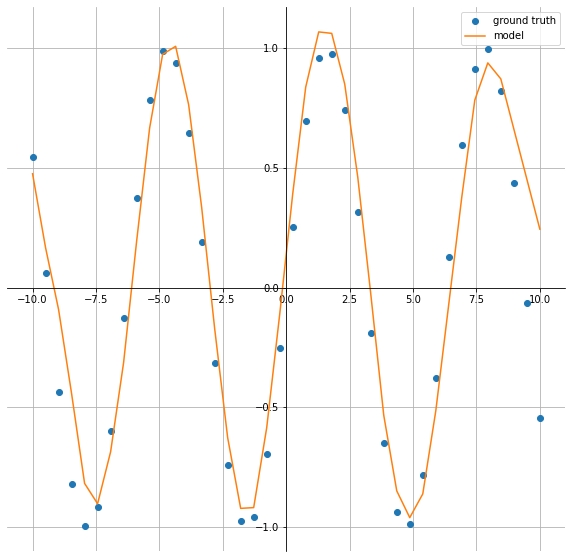

Epoch: 6000; Train Loss: 0.025420159101486206


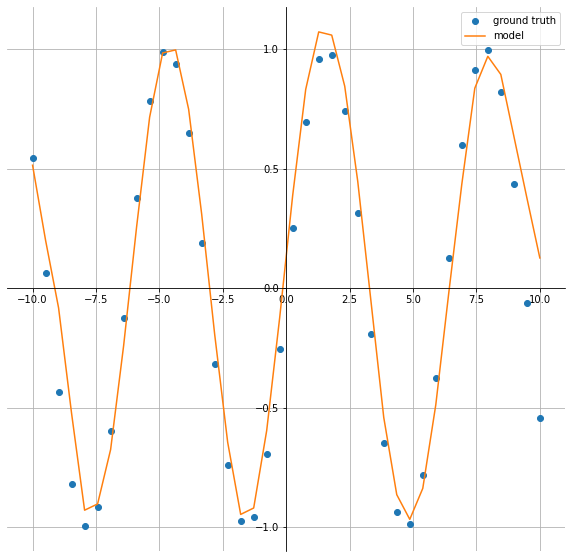

Epoch: 7000; Train Loss: 0.014422852545976639


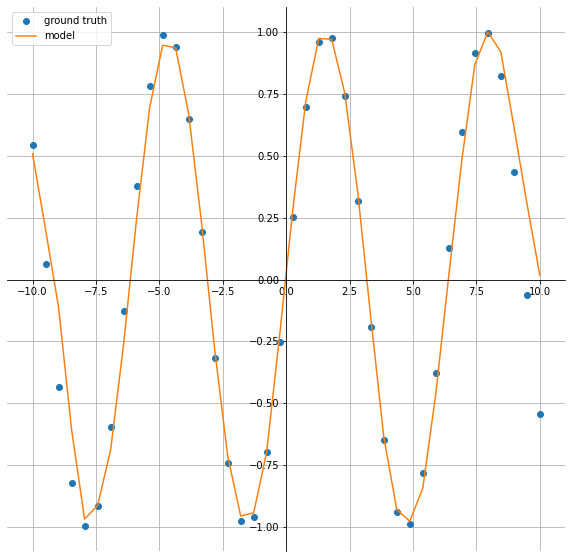

Epoch: 8000; Train Loss: 0.011043591424822807


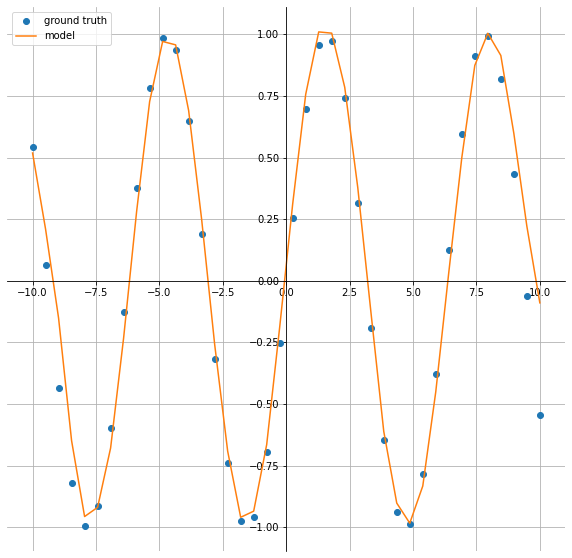

Epoch: 9000; Train Loss: 0.014153683558106422


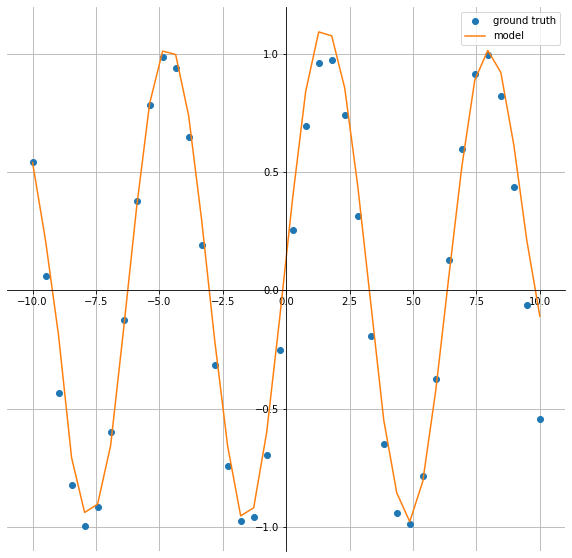

Test Loss: 0.00776536762714386


In [14]:
epochs = 10000
for t in range(epochs):
    train_loss = train(multimodel, train_dataloader, lossfunc, optimizer)
    if t % 1000 == 0:
        print(f"Epoch: {t}; Train Loss: {train_loss}")
        plot_comparinson(f, multimodel, nsamples=40)

test_loss = test(multimodel, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")